In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

root = '/content/drive/MyDrive/ds_divya'

folders = [
    root,
    f'{root}/csv_files',
    f'{root}/outputs'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created successfully!")


Folder structure created successfully!


In [ ]:
import pandas as pd
import gdown
import os

trader_file_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
sentiment_file_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

trader_path = f'{root}/csv_files/raw_traders.csv'
sentiment_path = f'{root}/csv_files/fear_greed.csv'

# Download files from Google Drive using gdown
gdown.download(f'https://drive.google.com/uc?id={trader_file_id}', trader_path, quiet=False)
gdown.download(f'https://drive.google.com/uc?id={sentiment_file_id}', sentiment_path, quiet=False)

# Read the downloaded CSV files
traders = pd.read_csv(trader_path, low_memory=False)
fear_greed = pd.read_csv(sentiment_path, low_memory=False)

print("Files downloaded and read successfully!")


In [ ]:

traders.columns = [c.strip().lower().replace(' ', '_') for c in traders.columns]
fear_greed.columns = [c.strip().lower().replace(' ', '_') for c in fear_greed.columns]

print("Trader cols:", traders.columns.tolist()[:30])
print("Fear_greed cols:", fear_greed.columns.tolist())
print(traders.head(3))


Trader cols: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Fear_greed cols: ['timestamp', 'value', 'classification', 'date']
                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   size_tokens  size_usd side     timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   closed_pnl                                   transaction_hash     order_id  \
0         0.0  0xec09451986a187

In [ ]:
#Convert time columns to datetimes and create a 'date' column (normalize to date)
import numpy as np
from datetime import datetime, timezone

# Example: traders has 'timestamp_ist' with format '02-12-2024 22:50' (dd-mm-yyyy HH:MM)
possible_time_cols = [c for c in traders.columns if 'timestamp' in c or 'time' in c or 'date' in c]
print("Possible trader time cols:", possible_time_cols)

# Adapt these names to your file:
TRADER_TIME_COL = 'timestamp_ist' if 'timestamp_ist' in traders.columns else possible_time_cols[0]

# parse trader timestamps robustly
def parse_mixed_datetime(s):
    # try common formats
    for fmt in ("%d-%m-%Y %H:%M", "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M:%S", "%m/%d/%Y %H:%M"):
        try:
            return datetime.strptime(s, fmt)
        except Exception:
            continue
    # fallback: try pandas to_datetime
    try:
        return pd.to_datetime(s, infer_datetime_format=True, utc=False)
    except Exception:
        return pd.NaT

# Apply parse
traders[TRADER_TIME_COL] = traders[TRADER_TIME_COL].astype(str)
traders['time_parsed'] = traders[TRADER_TIME_COL].apply(parse_mixed_datetime)
traders['date'] = pd.to_datetime(traders['time_parsed']).dt.normalize()

# fear_greed dataset sample shows UNIX timestamps (e.g., 1517463000) and a date column — handle both
if 'timestamp' in fear_greed.columns and fear_greed['timestamp'].dtype in [np.int64, np.float64, 'int64', 'float64']:
    fear_greed['time_parsed'] = pd.to_datetime(fear_greed['timestamp'], unit='s')
elif 'timestamp' in fear_greed.columns:
    fear_greed['time_parsed'] = pd.to_datetime(fear_greed['timestamp'], unit='s', errors='coerce')
elif 'date' in fear_greed.columns:
    fear_greed['time_parsed'] = pd.to_datetime(fear_greed['date'], errors='coerce')

fear_greed['date'] = pd.to_datetime(fear_greed['time_parsed']).dt.normalize()

print(traders[['date','time_parsed']].head())
print(fear_greed[['date','time_parsed']].head())

Possible trader time cols: ['timestamp_ist', 'timestamp', 'time_parsed', 'date']
        date         time_parsed
0 2024-12-02 2024-12-02 22:50:00
1 2024-12-02 2024-12-02 22:50:00
2 2024-12-02 2024-12-02 22:50:00
3 2024-12-02 2024-12-02 22:50:00
4 2024-12-02 2024-12-02 22:50:00
        date         time_parsed
0 2018-02-01 2018-02-01 05:30:00
1 2018-02-02 2018-02-02 05:30:00
2 2018-02-03 2018-02-03 05:30:00
3 2018-02-04 2018-02-04 05:30:00
4 2018-02-05 2018-02-05 05:30:00


In [ ]:
#  Convert numeric-like columns and compute notional = size_usd if present else size_tokens * execution_price
num_cols = ['execution_price','size_tokens','size_usd','closed_pnl','fee','leverage']  # adapt to your CSV names
for c in num_cols:
    if c in traders.columns:
        traders[c] = pd.to_numeric(traders[c], errors='coerce')

# Some datasets use 'size usd' or 'size_usd', check both:
if 'size_usd' not in traders.columns and 'size_usd' not in traders.columns:
    # compute
    if 'size_tokens' in traders.columns and 'execution_price' in traders.columns:
        traders['notional'] = traders['size_tokens'] * traders['execution_price']
else:
    traders['notional'] = traders.get('size_usd', traders.get('notional', None))

# Ensure closedPnL numeric
if 'closed_pnl' in traders.columns:
    traders['closed_pnl'] = pd.to_numeric(traders['closed_pnl'], errors='coerce')

# Create indicator: profitable trade
traders['is_profitable'] = traders['closed_pnl'].fillna(0) > 0

# Define CSV_DIR using the root variable
CSV_DIR = f'{root}/csv_files'

# Save an intermediate processed file
traders.to_csv(os.path.join(CSV_DIR, 'processed_traders.csv'), index=False)
print("Processed traders saved:", traders.shape)

Processed traders saved: (211224, 20)


In [ ]:
# Merge sentiment classification into trades by date
# Ensure sentiment classification column name: 'classification' or 'classification' variant
sent_col = 'classification' if 'classification' in fear_greed.columns else next((c for c in fear_greed.columns if 'class' in c), None)
if sent_col is None:
    raise ValueError("Cannot find sentiment/classification column in sentiment dataset")

# pick the sentiment label (e.g., 'Fear', 'Greed', 'Extreme Fear' etc.)
sent_small = fear_greed[['date', sent_col]].drop_duplicates().rename(columns={sent_col: 'sentiment'})

# Left-join traders on date (trades -> daily sentiment)
merged = traders.merge(sent_small, on='date', how='left')

# If sentiment is missing for some trade dates, optionally forward/backward fill using nearest day
merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(method='bfill')

# Quick check
print("Merged:", merged.shape)
print(merged[['date','sentiment']].drop_duplicates().head(10))

# Save merged
merged.to_csv(os.path.join(CSV_DIR, 'trades_with_sentiment.csv'), index=False)


/tmp/ipython-input-3308723432.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment'] = merged['sentiment'].fillna(method='ffill').fillna(method='bfill')


Merged: (211224, 21)
          date      sentiment
0   2024-12-02  Extreme Greed
44  2024-12-03  Extreme Greed
189 2024-12-04  Extreme Greed
190 2025-03-04   Extreme Fear
211 2025-03-05   Extreme Fear
220 2025-03-11   Extreme Fear
224 2025-03-18           Fear
262 2025-04-08   Extreme Fear
295 2025-04-09   Extreme Fear
308 2025-04-10           Fear


In [ ]:
#  Aggregate to daily metrics
daily = merged.groupby('date').agg(
    net_pnl = ('closed_pnl', 'sum'),
    # avg_leverage = ('leverage', 'mean'),
    # median_leverage = ('leverage', 'median'),
    total_volume = ('notional', 'sum'),
    trades = ('account', 'count'),
    profit_rate = ('is_profitable', 'mean'),
    sentiment = ('sentiment', 'first')
).reset_index()

daily['cumulative_net_pnl'] = daily['net_pnl'].cumsum()
daily.to_csv(os.path.join(CSV_DIR, 'daily_aggregates.csv'), index=False)
display(daily.head())

,date,net_pnl,total_volume,trades,profit_rate,sentiment,cumulative_net_pnl
0,2023-05-01,0.000000,477.00,3,0.000000,Greed,0.000000
1,2023-12-05,0.000000,50005.83,9,0.000000,Extreme Greed,0.000000
2,2023-12-14,-205.434737,113203.35,11,0.363636,Greed,-205.434737
3,2023-12-15,-24.632034,10609.95,2,0.000000,Greed,-230.066771
4,2023-12-16,0.000000,15348.77,3,0.000000,Greed,-230.066771


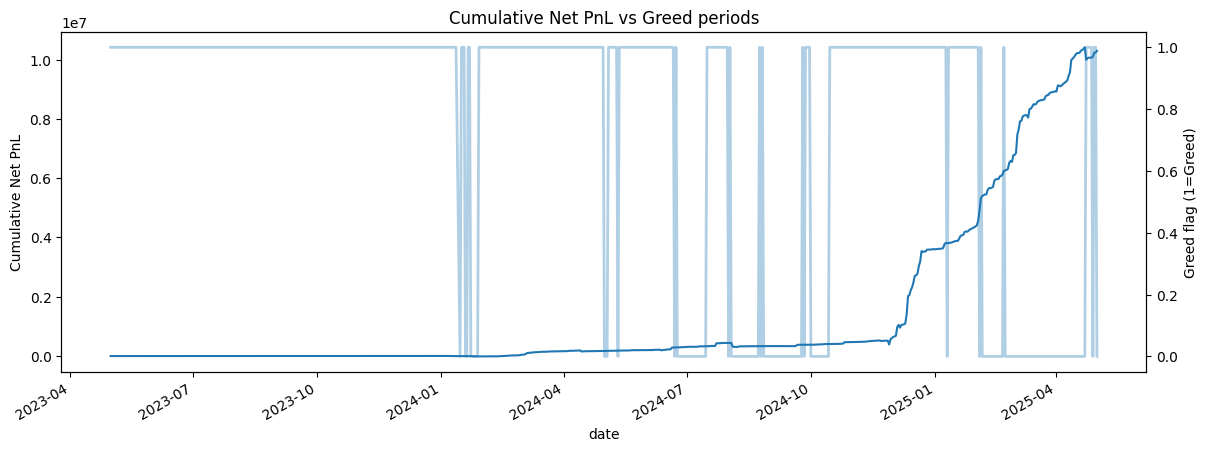

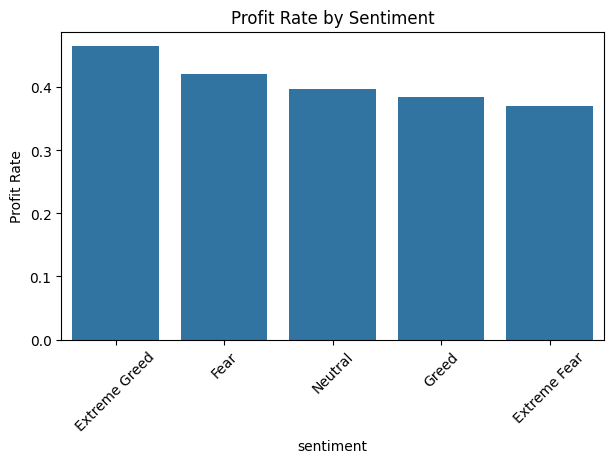

In [ ]:
# Plot sentiment vs cumulative PnL and leverage
import matplotlib.pyplot as plt
import seaborn as sns

# Define OUT_DIR using the root variable
OUT_DIR = f'{root}/outputs'

plt.figure(figsize=(14,5))
ax = plt.gca()
ax2 = ax.twinx()
daily.plot(x='date', y='cumulative_net_pnl', ax=ax, legend=False)
# plot sentiment as colored background: convert sentiment to numeric flag (Greed=1 else 0)
daily['greed_flag'] = daily['sentiment'].str.contains('Greed', case=False, na=False).astype(int)
ax2.plot(daily['date'], daily['greed_flag'], alpha=0.35, linewidth=2)
ax.set_ylabel('Cumulative Net PnL')
ax2.set_ylabel('Greed flag (1=Greed)')
plt.title('Cumulative Net PnL vs Greed periods')
plt.savefig(os.path.join(OUT_DIR, 'cumulative_pnl_vs_greed.png'), bbox_inches='tight', dpi=150)
plt.show()

# Profit rate by sentiment
plt.figure(figsize=(7,4))
pr = merged.groupby('sentiment')['is_profitable'].mean().reset_index().sort_values('is_profitable', ascending=False)
sns.barplot(data=pr, x='sentiment', y='is_profitable')
plt.ylabel('Profit Rate')
plt.title('Profit Rate by Sentiment')
plt.xticks(rotation=45)
plt.savefig(os.path.join(OUT_DIR, 'profit_rate_by_sentiment.png'), bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
#Mann-Whitney U test (non-parametric) for closed_pnl distributions
from scipy.stats import mannwhitneyu

# Build two samples
fear_pnl = merged.loc[merged['sentiment'].str.contains('Fear', case=False, na=False), 'closed_pnl'].dropna()
greed_pnl = merged.loc[merged['sentiment'].str.contains('Greed', case=False, na=False), 'closed_pnl'].dropna()

# if the sizes are too big, subsample for speed
if len(fear_pnl)>20000: fear_pnl = fear_pnl.sample(20000, random_state=42)
if len(greed_pnl)>20000: greed_pnl = greed_pnl.sample(20000, random_state=42)

stat, p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
print("Mann-Whitney U test: stat=%.4f p=%.4g" % (stat, p))


Mann-Whitney U test: stat=198259972.0000 p=0.1062


In [ ]:
#Build a simple model to predict is_profitable using light features
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Prepare account-day features: groupby account+date
acc_daily = merged.groupby(['account','date']).agg(
    trades=('order_id' if 'order_id' in merged.columns else 'trade_id','count'),
    # avg_leverage=('leverage','mean'),
    # median_leverage=('leverage','median'),
    total_volume=('notional','sum'),
    net_pnl=('closed_pnl','sum'),
    profit_rate=('is_profitable','mean'),
    sentiment=('sentiment','first')
).reset_index()

# target: profitable day? (net_pnl > 0)
acc_daily['target_profitable_day'] = acc_daily['net_pnl'] > 0

# encode sentiment into numeric
acc_daily['sentiment_greed'] = acc_daily['sentiment'].str.contains('Greed', case=False, na=False).astype(int)

features = ['trades','total_volume','sentiment_greed'] # Removed 'avg_leverage'
X = acc_daily[features].fillna(0)
y = acc_daily['target_profitable_day'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, model.predict(X_test)))

AUC: 0.663731778425656
              precision    recall  f1-score   support

           0       0.62      0.33      0.43       175
           1       0.69      0.88      0.77       294

    accuracy                           0.68       469
   macro avg       0.66      0.61      0.60       469
weighted avg       0.66      0.68      0.65       469



In [ ]:
# Cell 12 — Save processed datasets and aggregated outputs to Drive
acc_daily.to_csv(os.path.join(CSV_DIR, 'account_daily_aggregates.csv'), index=False)
daily.to_csv(os.path.join(CSV_DIR, 'daily_aggregates.csv'), index=False)
merged.to_csv(os.path.join(CSV_DIR, 'merged_trades_sentiment.csv'), index=False)

print("All CSVs saved to:", CSV_DIR)
print("Plots saved to:", OUT_DIR)


All CSVs saved to: /content/drive/MyDrive/ds_divya/csv_files
Plots saved to: /content/drive/MyDrive/ds_divya/outputs
